# Sentiment Analysis on IMDB Movie Reviews

## Loading Data

In [1]:
!pip install joblib

In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import re
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from joblib import dump

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# IMDB Dataset: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!wget "/content/test/" http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

/content/test/: Scheme missing.
--2025-02-02 04:07:43--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  11.3MB/s    in 15s     

2025-02-02 04:07:58 (5.46 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]

FINISHED --2025-02-02 04:07:58--
Total wall clock time: 15s
Downloaded: 1 files, 80M in 15s (5.46 MB/s)


In [4]:
# Extract downloaded TAR files
!mkdir "/content/test"
!tar xvzf "/content/aclImdb_v1.tar.gz" -C "/content/test"

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [5]:
# Read reviews into a Pandas dataframe
def fetch_reviews(path):
  data = []
  files = [f for f in os.listdir(path)]
  for file in files:
    with open(path+file, "r", encoding='utf8') as f:
      data.append(f.read())

  return data

Let's load the positive and negative reviews for the training and testing into Pandas dataframes and assign a label of "1" to positive reviews and "0" to negative reviews.

In [6]:
# Label: 1 = positive, 0 = negative
df_train_pos = pd.DataFrame({'review': fetch_reviews('/content/test/aclImdb/train/pos/'), 'label': 1})
df_train_neg = pd.DataFrame({'review': fetch_reviews('/content/test/aclImdb/train/neg/'), 'label': 0})

df_test_pos = pd.DataFrame({'review': fetch_reviews('/content/test/aclImdb/test/pos/'), 'label': 1})
df_test_neg = pd.DataFrame({'review': fetch_reviews('/content/test/aclImdb/test/neg/'), 'label': 0})

df = pd.concat([df_train_pos, df_train_neg, df_test_pos, df_test_neg], ignore_index=True)
print("Total reviews in df: ", df.shape)

df.head()

Total reviews in df:  (50000, 2)


,review,label
0,The Lion King 1 1/2 is a very cute story to go...,1
1,Lawrence Olivier and Merle Oberon did two movi...,1
2,I couldn't find anyone to watch DiG! with me b...,1
3,"The Master Blackmailer, based off of Sir Arthu...",1
4,"In my years of attending film festivals, I hav...",1


In [7]:
df.tail(5)

,review,label
49995,This movie has been advertised for over three ...,0
49996,Hello it is I Derrick Cannon and I welcome you...,0
49997,This movie is so God-awful that it was literal...,0
49998,Do not waste your money or time. Terrible movi...,0
49999,...this one just isn't worth the cost of a mov...,0


In [8]:
df[df.label == 0 ].count()

,0
review,25000
label,25000


In [9]:
df[df.label == 1 ].count()

,0
review,25000
label,25000


We have balanced data. Let's visualize.

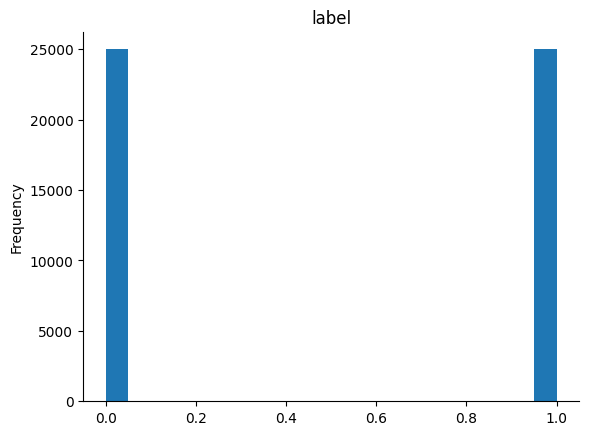

In [10]:
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
df[df.label == 0].loc[12500].review

"I wanted to see this movie ever since it was first advertised on TV. I went to Tinsel Town to see it Last Night at 7:40. I regret the day that wasted my ticket on this trash when I could of saw something better. The beginning was all a bunch sex trash and cliches. They exaggerated the way love works in reality. All of the girls were stereo types. The boyfriend was too stupid for his own age. The passing gases that the pregnant girl kept having barely got any laughs. The bank robbery was completely boring with gags that have been used in other movies. Their getaway car was an old beat up Chevy van that they claimed that had no breaks. Hey why didn't they get nice girlish vehicle for the robbery instead? It might have boosted the audience opinion about the movie. This movie was very low low low low low budgeted since nothing in there was damaged or destroyed. This movie had a lot of stuff in it that would drive Christian people nuts. Hey I even expected a car chase scene because all ban

# Data Preprocessing

In [12]:
stop_words = stopwords.words('english')

# Removing "not" from the stopwords list as it conveys negative sentiment value
stop_words.remove('not')

lemmatizer = WordNetLemmatizer()

In [13]:
def data_preprocessing(review):

  # Remove HTML tags and numbers
  review = re.sub(re.compile('<.*?>'), '', review)
  review =  re.sub('[^A-Za-z0-9]+', ' ', review)

  # Lowercase
  review = review.lower()

  # Tokenization
  tokens = nltk.word_tokenize(review)

  # Stopword removal
  review = [word for word in tokens if word not in stop_words]

  # Lemmatization
  review = [lemmatizer.lemmatize(word) for word in review]

  review = ' '.join(review)

  return review

In [14]:
df

,review,label
0,The Lion King 1 1/2 is a very cute story to go...,1
1,Lawrence Olivier and Merle Oberon did two movi...,1
2,I couldn't find anyone to watch DiG! with me b...,1
3,"The Master Blackmailer, based off of Sir Arthu...",1
4,"In my years of attending film festivals, I hav...",1
...,...,...
49995,This movie has been advertised for over three ...,0
49996,Hello it is I Derrick Cannon and I welcome you...,0
49997,This movie is so God-awful that it was literal...,0
49998,Do not waste your money or time. Terrible movi...,0


In [15]:
# Preprocess data (may take a couple of minutes)
df['preprocessed_review'] = df['review'].apply(lambda review: data_preprocessing(review))

df.head()

,review,label,preprocessed_review
0,The Lion King 1 1/2 is a very cute story to go...,1,lion king 1 1 2 cute story go along lion king ...
1,Lawrence Olivier and Merle Oberon did two movi...,1,lawrence olivier merle oberon two movie togeth...
2,I couldn't find anyone to watch DiG! with me b...,1,find anyone watch dig one knew fan either band...
3,"The Master Blackmailer, based off of Sir Arthu...",1,master blackmailer based sir arthur conan doyl...
4,"In my years of attending film festivals, I hav...",1,year attending film festival seen many little ...


In [16]:
df['review'][5]

'The Secret Fury, in many ways a run-of-the-mill romantic suspense drama (directed by Mel Ferrer) boasts top-notch principals in Colbert and Ryan; it stays puzzling if not quite gripping until towards the end, when implausibility conquers suspension of disbelief -- as so often it does in this genre. But for some viewers the film\'s highlight will be the portrayal of blowsy Leah by Vivian Vance -- the immortal Ethel Mertz on "I Love Lucy." Oddly, Vance had very few film roles; her true home was Broadway, where (among other gigs) she understudied for Ethel Merman. Here she contributes a winning turn as a chambermaid suborned to play a minor part in a nefarious scheme; watch her half-heartedly trying to wave away the smoke when she\'s puffing a furtive cigarette in the hotel\'s linen-storage room -- a transgression for which she ultimately pays the supreme penalty.'

In [17]:
df['preprocessed_review'][5]

'secret fury many way run mill romantic suspense drama directed mel ferrer boast top notch principal colbert ryan stay puzzling not quite gripping towards end implausibility conquers suspension disbelief often genre viewer film highlight portrayal blowsy leah vivian vance immortal ethel mertz love lucy oddly vance film role true home broadway among gig understudied ethel merman contributes winning turn chambermaid suborned play minor part nefarious scheme watch half heartedly trying wave away smoke puffing furtive cigarette hotel linen storage room transgression ultimately pay supreme penalty'

# Train-Test Split
7 train : 3 test

In [18]:
data = df.copy()
y = data['label'].values
data.drop(['label'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (35000, 2) (35000,)
Test data: (15000, 2) (15000,)


# Vectorize - TF-IDF

In [19]:
vectorizer = TfidfVectorizer(min_df=10) # minimum document frequency

X_train_tfidf = vectorizer.fit_transform(X_train['preprocessed_review'])

print('Training Data TF-IDF Shape: ', X_train_tfidf.shape)

Training Data TF-IDF Shape:  (35000, 19478)


In [20]:
X_test_tfidf = vectorizer.transform(X_test['preprocessed_review'])

print('Testing Data TF-IDF Shape: ', X_test_tfidf.shape)

Testing Data TF-IDF Shape:  (15000, 19478)


In [21]:
print(X_test_tfidf[0])

  (0, 10)	0.11676473113134177
  (0, 425)	0.09810560493800247
  (0, 1426)	0.1500809560859301
  (0, 1927)	0.12441845818796234
  (0, 5234)	0.3260736744594576
  (0, 6155)	0.1366721649890796
  (0, 7388)	0.08185299495398898
  (0, 7556)	0.07608840718902164
  (0, 7674)	0.23123567144879156
  (0, 8336)	0.22465505936699626
  (0, 9624)	0.20634991558725296
  (0, 9757)	0.15221762864198424
  (0, 9758)	0.1658052441034225
  (0, 10776)	0.27524943338270025
  (0, 11516)	0.11121665811682666
  (0, 11583)	0.13002181886407208
  (0, 11590)	0.12353881811689561
  (0, 12062)	0.16554125794336183
  (0, 12271)	0.13172974022801232
  (0, 13964)	0.17950260204804694
  (0, 15657)	0.48359647603734285
  (0, 16306)	0.29095410504823915
  (0, 18356)	0.2598772314504102
  (0, 18493)	0.1439788638970946


# Model Training

In [22]:
X_train_tfidf, y_train

(<35000x19478 sparse matrix of type '<class 'numpy.float64'>'
 	with 3224645 stored elements in Compressed Sparse Row format>,
 array([0, 1, 1, ..., 1, 1, 1]))

Let's go with Logistic Regression as we have categorical data.

In [23]:
model = LogisticRegression(max_iter=1000, random_state=2024)
model.fit(X_train_tfidf, y_train)

# Generate predictions on the test data
y_pred = model.predict(X_test_tfidf)

print(y_pred), y_test

[0 1 0 ... 0 1 0]


(None, array([0, 1, 0, ..., 1, 1, 0]))

# Evaluate

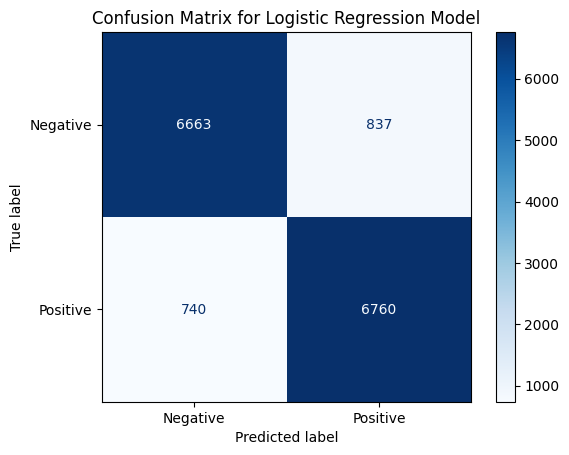

In [24]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

In [25]:
X_test_tfidf[0][0]

<1x19478 sparse matrix of type '<class 'numpy.float64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [26]:
# Generate predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Calculate and print the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Show f1 score, accuracy, precision, recall
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8948666666666667
Precision: 0.8898249308937739
Recall: 0.9013333333333333
F1 Score: 0.8955421606941777


# Pickle for deployment
... with joblib

In [27]:
dump(model, 'model.joblib')
dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']